<a href="https://colab.research.google.com/github/kirath2205/Neural-Network-Assignment-1/blob/main/start_1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

import math
import matplotlib.pyplot as plt

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup , Embedding , Flatten

In [4]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


#Question 1


In [5]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="one_hot") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [6]:

#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

In [8]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature encoded as string

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ] 
)

In [9]:
all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]

In [10]:
from keras import backend as K

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model = keras.Model(all_inputs, output)
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [11]:
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[r2_score])
model.summary()

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[model_checkpoint_callback])

In [ ]:
history.history['root_mean_squared_error-question1']=[]
history.history['val_root_mean_squared_error-question1']=[]

for i in range(len(history.history['loss'])):
    history.history['root_mean_squared_error-question1'].append(math.sqrt(history.history['loss'][i]))

for i in range(len(history.history['val_loss'])):
    history.history['val_root_mean_squared_error-question1'].append(math.sqrt(history.history['val_loss'][i]))

plt.plot(history.history['root_mean_squared_error-question1'])
plt.plot(history.history['val_root_mean_squared_error-question1'])
plt.title('RMSE vs epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
min_loss = float('inf')
best_r2_score = float('-inf')
epoch_of_min_loss=-1
for epoch in range(100):
  if(history.history['val_root_mean_squared_error'][epoch]<min_loss):
    min_loss = history.history['val_root_mean_squared_error'][epoch]
    epoch_of_min_loss = epoch
    best_r2_score = history.history['r2_score'][epoch]

In [ ]:
model.load_weights(checkpoint_filepath)
test_predictions = model.predict(val_ds)

In [ ]:
test_predictions_batch_128 = test_predictions[:128]
true_values = np.concatenate([y for x, y in val_ds], axis=0)
true_values_batch_128 = true_values[:128]
plt.scatter(true_values_batch_128, test_predictions_batch_128)

In [ ]:
print('Minimum test rmse score ', min_loss)
print('best r2 score ',best_r2_score)

Minimum test rmse score  64934.946893025175
best r2 score  0.8815845847129822


#Question 2

In [12]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [13]:
#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

In [14]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)
month_output_dim = (math.floor(month_encoded.shape[1]/2))
month_encoded_embedding = tf.keras.layers.Embedding(input_dim = month_encoded.shape[1] , output_dim = month_output_dim)(month_encoded)
month_encoded_embedding_flatten = Flatten()(month_encoded_embedding)

# Categorical feature encoded as string

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)
storey_range_output_dim = (math.floor(storey_range_encoded.shape[1]/2))
storey_range_encoded_embedding = tf.keras.layers.Embedding(input_dim = storey_range_encoded.shape[1] , output_dim = storey_range_output_dim)(storey_range_encoded)
storey_range_encoded_embedding_flatten = Flatten()(storey_range_encoded_embedding)

flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
flat_model_type_output_dim = (math.floor(flat_model_type_encoded.shape[1]/2))
flat_model_type_encoded_embedding = tf.keras.layers.Embedding(input_dim = flat_model_type_encoded.shape[1] , output_dim = flat_model_type_output_dim)(flat_model_type_encoded)
flat_model_type_encoded_embedding_flatten = Flatten()(flat_model_type_encoded_embedding)

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

all_features = layers.concatenate(
    [
        month_encoded_embedding_flatten,
        flat_model_type_encoded_embedding_flatten,
        storey_range_encoded_embedding_flatten,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ] 
)

In [15]:
all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]


In [ ]:
# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model = keras.Model(all_inputs, output)
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [12]:
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[r2_score])
model.summary()

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[model_checkpoint_callback])

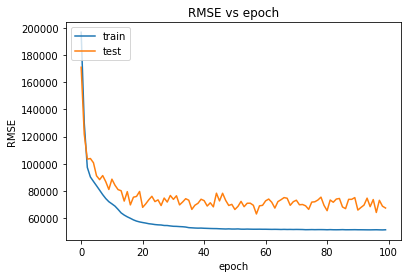

In [17]:
history.history['root_mean_squared_error-question2']=[]
history.history['val_root_mean_squared_error-question2']=[]

for i in range(len(history.history['loss'])):
    history.history['root_mean_squared_error-question2'].append(math.sqrt(history.history['loss'][i]))

for i in range(len(history.history['val_loss'])):
    history.history['val_root_mean_squared_error-question2'].append(math.sqrt(history.history['val_loss'][i]))

plt.plot(history.history['root_mean_squared_error-question2'])
plt.plot(history.history['val_root_mean_squared_error-question2'])
plt.title('RMSE vs epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
min_loss=float('inf')
best_r2_score=float('-inf')
epoch_of_min_loss=-1
for epoch in range(100):
  if(history.history['val_root_mean_squared_error-question2'][epoch]<min_loss):
    min_loss = history.history['val_root_mean_squared_error-question2'][epoch]
    epoch_of_min_loss = epoch
    best_r2_score = history.history['val_r2_score'][epoch]

In [19]:
model.load_weights(checkpoint_filepath)
test_predictions = model.predict(val_ds)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


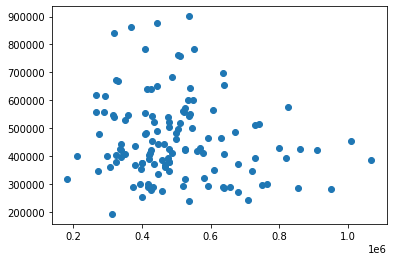

In [20]:
test_predictions_batch_128 = test_predictions[:128]
true_values = np.concatenate([y for x, y in val_ds], axis=0)
true_values_batch_128 = true_values[:128]
plt.scatter(true_values_batch_128, test_predictions_batch_128)

In [21]:
print('Minimum test rmse score ', min_loss)
print('best r2 score ',best_r2_score)

Minimum test rmse score  63077.59488122546
best r2 score  0.8840727806091309


#Question 3


In [ ]:
from keras.callbacks import EarlyStopping
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10
)

result= {}

features_mapping = {
    'month': month_encoded_embedding_flatten,
    'flat_model_type': flat_model_type_encoded_embedding_flatten,
    'storey_range': storey_range_encoded_embedding_flatten,
    'floor_area_sqm': floor_area_sqm_encoded,
    'remaining_lease_years': remaining_lease_years_encoded,
    'degree_centrality': degree_centrality_encoded,
    'eigenvector_centrality': eigenvector_centrality_encoded,
    'dist_to_nearest_stn': dist_to_nearest_stn_encoded,
    'dist_to_dhoby': dist_to_dhoby_encoded
}


def features_to_tensors_mapping(features):
    tensor_list = []
    for feature in features:
        tensor_list.append(features_mapping[feature])
    return tensor_list

def find_best_r2score_root_mean_square_error(history):
  best_root_mean_square_error=float('inf')
  best_r2_score=float('-inf')

  for epoch in range(len(history.history['val_r2_score'])):

    if(history.history['val_r2_score'][epoch] >= best_r2_score):
      best_root_mean_square_error = math.sqrt(history.history['val_loss'][epoch])
      best_r2_score = history.history['val_r2_score'][epoch]

  return best_r2_score , best_root_mean_square_error

def build_model(feature_list):

  concatinate_layer = layers.concatenate(feature_list)
  x = layers.Dense(10, activation="relu")(concatinate_layer)
  output = layers.Dense(1, activation="linear")(x)
  model = keras.Model(all_inputs, output)
  model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[r2_score])
  history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])
  print()
  return history


def recursive_feature_elimination(features):

  if(len(features)<=1):
    return
  best_r2_score = float('-inf')
  best_root_mean_square_error = float('inf')
  best_feature_index=-1
  for i in range(len(features)):
    tensor_list = features_to_tensors_mapping(features[:i]+features[i+1:])
    history = build_model(tensor_list)
    r2_score , root_mean_square_error = find_best_r2score_root_mean_square_error(history)
    tf.keras.backend.clear_session()
    if(best_r2_score < r2_score):
      best_feature_index = i
      best_r2_score = r2_score
      best_root_mean_square_error = root_mean_square_error
  tensor_tuple = features[:best_feature_index]+features[best_feature_index+1:]
  result[tuple(tensor_tuple)] = [best_r2_score , best_root_mean_square_error]
  recursive_feature_elimination(features[:best_feature_index]+features[best_feature_index+1:])


feature_list = [
    'month',
    'flat_model_type',
    'storey_range',
    'floor_area_sqm',
    'remaining_lease_years',
    'degree_centrality',
    'eigenvector_centrality',
    'dist_to_nearest_stn',
    'dist_to_dhoby'           
]

all_features=[
        month_encoded_embedding_flatten,
        flat_model_type_encoded_embedding_flatten,
        storey_range_encoded_embedding_flatten,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ]

history = build_model(all_features)
best_r2_score , best_root_mean_square_error = find_best_r2score_root_mean_square_error(history)
result[tuple(feature_list)] = [best_r2_score , best_root_mean_square_error]
tf.keras.backend.clear_session()
recursive_feature_elimination(feature_list)



In [36]:
for key in result.keys():
  print(key,'  ',result[key])

('month', 'flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'degree_centrality', 'eigenvector_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby')    [0.5722963809967041, 105227.50302083576]
('month', 'flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'degree_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby')    [0.5722089409828186, 105202.25214319321]
('flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'degree_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby')    [0.5938809514045715, 102500.6755099692]
('flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'dist_to_nearest_stn', 'dist_to_dhoby')    [0.6215704679489136, 98817.02590141034]
('flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'dist_to_nearest_stn')    [0.5966245532035828, 102266.94355460125]
('flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years')    [0.575168728828

In [54]:
final_table = {}
for key in result.keys():
  temp_list=[]
  for element in feature_list:
    if(element not in key):
      temp_list.append(element)
  final_table[tuple(temp_list)] = [result[key][0],(result[key][1])]


In [60]:
eliminated_features = []
r2_scores_list = []
root_mean_square_error_list = []
for key in result.keys():
  eliminated_features.append(key)
  r2_scores_list.append(result[key][0])
  root_mean_square_error_list.append(result[key][1])

In [64]:
rfe_table = pd.DataFrame(list(zip(eliminated_features , r2_scores_list , root_mean_square_error_list)) , columns=['Eliminated features','R2_Score','Root_Mean_Square_Error'])

In [65]:
rfe_table

,Eliminated features,R2_Score,Root_Mean_Square_Error
0,"(month, flat_model_type, storey_range, floor_a...",0.572296,105227.503021
1,"(month, flat_model_type, storey_range, floor_a...",0.572209,105202.252143
2,"(flat_model_type, storey_range, floor_area_sqm...",0.593881,102500.675510
3,"(flat_model_type, storey_range, floor_area_sqm...",0.621570,98817.025901
4,"(flat_model_type, storey_range, floor_area_sqm...",0.596625,102266.943555
5,"(flat_model_type, storey_range, floor_area_sqm...",0.575169,104568.788001
6,"(flat_model_type, storey_range, floor_area_sqm)",0.520806,111309.984170
7,"(flat_model_type, storey_range)",0.499495,113688.546899
8,"(flat_model_type,)",0.484197,115406.184375
